# Neural Net Model for Sentence Categorization

A Neural Network model to help classify sentences as important, or not important enough to be part of a summary

Built using Keras

https://towardsdatascience.com/building-a-deep-learning-model-using-keras-1548ca149d37

In [121]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from os.path import join

In [2]:
FEATURES_DIR = join("..", "feature_extraction", "feature_outputs")
DATA_FILES_DIR = join("..", "feature_extraction", "data_files")
sentence_vectors_filename = join(FEATURES_DIR, "sentence_vectors.csv")
summarized_chat_date_partitions_filename = join(DATA_FILES_DIR, "summarized_chat_date_partitions_cumulative_count.csv")

In [3]:
# read in data using pandas. This takes a couple of seconds
# sentence_vectors_df = pd.read_csv(sentence_vectors_filename)

In [4]:
summarized_chat_date_partitions = pd.read_csv(summarized_chat_date_partitions_filename)

In [5]:
summarized_chat_date_partitions.tail(4)

,min_log_id,date_of_log,chat_line_count,cumulative_count
23,531627,2001-11-12,1348,20067
24,579591,2001-10-24,162,20229
25,586206,2001-10-23,165,20394
26,623684,2001-10-25,321,20715


Get the first chat log id for the third last chat date. Use the last three chat log dates for testing. The rest to be used for training

In [6]:
index_for_train_test_split = summarized_chat_date_partitions.tail(4)["cumulative_count"]
index_for_train_test_split = index_for_train_test_split.values[0]
index_for_train_test_split

20067

In [7]:
sentence_vectors_df.shape

(659165, 150)

In [8]:
sentence_vectors_df.head(3)

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,2.661401e-11,4.864283e-10,2.155568e-09,2.559706e-09,2.042709e-09,-9.672571e-10,-1.011755e-09,-7.997459e-10,4.663964e-10,9.187571e-10,...,1.407428e-10,2.914283e-09,-2.747660e-10,4.775819e-10,-2.102210e-10,2.105973e-09,1.021558e-09,2.252703e-10,1.863019e-10,8.672187e-10
1,1.022276e-10,-1.955946e-09,1.327970e-09,1.232455e-09,2.482607e-09,-2.743914e-10,-1.086364e-09,-2.488646e-10,1.262163e-09,9.180705e-10,...,-6.610669e-10,-1.520207e-09,8.983655e-10,8.465219e-10,3.878689e-11,2.797304e-09,1.089229e-10,1.791956e-09,7.814260e-10,-5.340539e-10
2,5.006117e-09,1.308245e-09,-1.726347e-09,-2.326718e-09,2.644977e-09,-6.860966e-09,-2.840772e-09,-1.275456e-09,-3.629866e-09,2.648799e-09,...,-4.186932e-10,-4.387442e-09,-4.779804e-09,1.756883e-09,1.552142e-09,-1.799109e-09,-2.763327e-09,-1.287349e-09,7.786218e-11,3.528413e-09


In [164]:
FEATURES_DATA_FILE = join(FEATURES_DIR, "summarized_chats_features.csv")
# read in data using pandas
unnormalized_chat_log_df = pd.read_csv(FEATURES_DATA_FILE)
chat_log_df = unnormalized_chat_log_df

In [165]:
chat_log_df.head()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
0,85350,0.000436,1,0,0.6249,0.000789,0.006050,2.758723,0.788992,0
1,85351,0.000871,13,0,0.0000,0.003486,0.026734,0.149401,0.042729,0
2,85352,0.001307,10,0,0.0000,0.004054,0.031086,0.180867,0.051728,0
3,85353,0.001743,5,0,0.0000,0.003645,0.027952,0.499669,0.142905,0
4,85354,0.002179,8,0,0.2263,0.002310,0.017715,0.295432,0.084493,0


In [166]:
chat_log_df.shape

(20715, 10)

### Normalizing The Data
Formula to normalize data
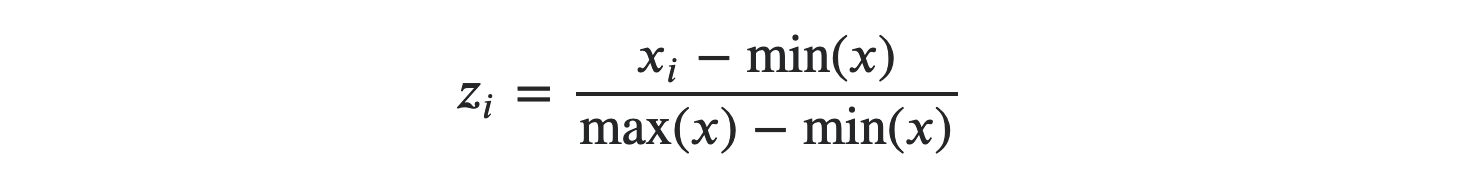

In [167]:
def normalize_data(value, minimum_value, maximum_value):
    return (value - minimum_value) / (maximum_value - minimum_value)

In [186]:
chat_data_max_values = chat_log_df.max()
chat_data_min_values = chat_log_df.min()
max_number_of_special_terms = chat_data_max_values.number_of_special_terms
max_sentence_length = chat_data_max_values.sentence_length
min_number_of_special_terms = chat_data_min_values.number_of_special_terms
min_sentence_length = chat_data_min_values.sentence_length

max_sentence_length

1.0

In [187]:
chat_log_df = unnormalized_chat_log_df
chat_log_df.sentence_length = (
    chat_log_df.sentence_length - min_sentence_length) / (
    max_sentence_length - min_sentence_length)
chat_log_df.number_of_special_terms = (
    chat_log_df.number_of_special_terms - min_number_of_special_terms) / (
    max_number_of_special_terms - min_number_of_special_terms)
print(chat_log_df.sentence_length.head())
print(chat_log_df.number_of_special_terms.head())

0    0.013699
1    0.178082
2    0.136986
3    0.068493
4    0.109589
Name: sentence_length, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: number_of_special_terms, dtype: float64


In [188]:
train_df = chat_log_df.loc[:index_for_train_test_split-1]
test_df = chat_log_df.loc[index_for_train_test_split:]
train_df.tail()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20062,532970,0.997033,0.013699,0.0,0.0000,0.001777,0.013628,3.129690,0.895088,0
20063,532971,0.997774,0.041096,0.0,0.0000,0.004070,0.031206,0.773078,0.221100,0
20064,532972,0.998516,0.013699,0.0,0.5267,0.002360,0.018096,2.527630,0.722900,0
20065,532973,0.999258,0.068493,0.0,-0.2500,0.002685,0.020592,0.354299,0.101329,0
20066,532974,1.000000,0.027397,0.0,0.0000,0.000900,0.006898,1.144535,0.327336,0


In [189]:
test_df.head()

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20067,579591,0.006173,0.232877,0.0,0.5994,0.000609,0.004672,0.100264,0.028675,0
20068,579592,0.012346,0.027397,0.0,-0.2960,0.000089,0.000686,1.104758,0.315960,0
20069,579593,0.018519,0.041096,0.0,-0.2960,0.000439,0.003367,0.642605,0.183785,0
20070,579594,0.024691,0.000000,0.0,-0.4404,0.000000,0.000000,0.000000,0.000000,0
20071,579595,0.030864,0.027397,0.0,0.0000,0.000553,0.004243,0.954243,0.272912,0


In [190]:
# check data has been read in properly
train_df.tail(10)

,log_id,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,mean_tf_idf,normalized_mean_tf_idf,mean_tf_isf,normalized_mean_tf_isf,is_summary
20057,532965,0.993323,0.054795,0.0,0.8225,0.001588,0.012177,0.500634,0.143181,0
20058,532966,0.994065,0.027397,0.0,0.4588,0.002247,0.017226,1.078724,0.308514,0
20059,532967,0.994807,0.013699,0.0,0.2960,0.001672,0.012821,1.698326,0.485720,0
20060,532968,0.995549,0.013699,0.0,0.0000,0.000897,0.006878,3.129690,0.895088,0
20061,532969,0.996291,0.000000,0.0,0.4588,0.000000,0.000000,0.000000,0.000000,0
20062,532970,0.997033,0.013699,0.0,0.0000,0.001777,0.013628,3.129690,0.895088,0
20063,532971,0.997774,0.041096,0.0,0.0000,0.004070,0.031206,0.773078,0.221100,0
20064,532972,0.998516,0.013699,0.0,0.5267,0.002360,0.018096,2.527630,0.722900,0
20065,532973,0.999258,0.068493,0.0,-0.2500,0.002685,0.020592,0.354299,0.101329,0
20066,532974,1.000000,0.027397,0.0,0.0000,0.000900,0.006898,1.144535,0.327336,0


In [191]:
#create a dataframe with all training data except the target column
columns_to_drop = ["log_id", "is_summary", "mean_tf_idf", "mean_tf_isf"]
train_X = train_df.drop(columns=columns_to_drop) # Keep only normalized columns
test_X = test_df.drop(columns=columns_to_drop)

assert train_X.shape[1] == test_X.shape[1]
#check that the target variable has been removed
train_X.head()

,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
0,0.000436,0.013699,0.0,0.6249,0.006050,0.788992
1,0.000871,0.178082,0.0,0.0000,0.026734,0.042729
2,0.001307,0.136986,0.0,0.0000,0.031086,0.051728
3,0.001743,0.068493,0.0,0.0000,0.027952,0.142905
4,0.002179,0.109589,0.0,0.2263,0.017715,0.084493


In [192]:
train_X.shape

(20067, 6)

In [193]:
test_X.head()

,absolute_sentence_position,sentence_length,number_of_special_terms,sentiment_score,normalized_mean_tf_idf,normalized_mean_tf_isf
20067,0.006173,0.232877,0.0,0.5994,0.004672,0.028675
20068,0.012346,0.027397,0.0,-0.2960,0.000686,0.315960
20069,0.018519,0.041096,0.0,-0.2960,0.003367,0.183785
20070,0.024691,0.000000,0.0,-0.4404,0.000000,0.000000
20071,0.030864,0.027397,0.0,0.0000,0.004243,0.272912


In [194]:
test_X.shape

(648, 6)

When separating the target column, we need to call the `to_categorical()` function so that column will be `one-hot encoded`. Currently, a chat line that is not a summary is represented with a `0` in the `is_summary` column and a chat line that is a summary is represented with a `1`. With one-hot encoding, the integer will be removed and a binary variable is inputted for each category.

In [196]:
# create a one hot encoding for the target column
train_y = to_categorical(train_df.is_summary)
test_y = to_categorical(test_df.is_summary)

# view one hot encoding numpy array
train_y[410: 430]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [197]:
train_y.shape

(20067, 2)

In [198]:
test_y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [199]:
test_y.shape

(648, 2)

The activation is `softmax`. Softmax makes the output sum up to `1` so the output can be interpreted as probabilities. The model will then make its prediction based on which option has a higher probability.

In [200]:

#create model
model = Sequential()

#get number of columns in training data
n_cols = train_X.shape[1]

#add model layers
model.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model.add(Dense(250, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [201]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 250)               1750      
_________________________________________________________________
dense_16 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_17 (Dense)             (None, 250)               62750     
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 502       
Total params: 127,752
Trainable params: 127,752
Non-trainable params: 0
_________________________________________________________________


We will use `categorical_crossentropy` for our loss function. This is the most common choice for classification. A lower score indicates that the model is performing better.

To make things even easier to interpret, we will use the ‘accuracy’ metric to see the accuracy score on the validation set at the end of each epoch.

In [202]:
#compile model using mse as a measure of model performance
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [203]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

In [204]:
#train model
history = model.fit(
    train_X, 
    train_y, 
    epochs=100
)

Epoch 1/10
20067/20067 [==============================] - 2s 83us/step - loss: 0.1418 - acc: 0.9675
Epoch 2/10
20067/20067 [==============================] - 1s 57us/step - loss: 0.1333 - acc: 0.9689
Epoch 3/10
20067/20067 [==============================] - 1s 70us/step - loss: 0.1328 - acc: 0.9689
Epoch 4/10
20067/20067 [==============================] - 1s 69us/step - loss: 0.1320 - acc: 0.9689
Epoch 5/10
20067/20067 [==============================] - 1s 67us/step - loss: 0.1316 - acc: 0.9689
Epoch 6/10
20067/20067 [==============================] - 1s 74us/step - loss: 0.1316 - acc: 0.9689
Epoch 7/10
20067/20067 [==============================] - 1s 69us/step - loss: 0.1312 - acc: 0.9689: 0s - loss: 0
Epoch 8/10
20067/20067 [==============================] - 1s 62us/step - loss: 0.1312 - acc: 0.9689
Epoch 9/10
20067/20067 [==============================] - 1s 58us/step - loss: 0.1311 - acc: 0.9689
Epoch 10/10
20067/20067 [==============================] - 1s 66us/step - loss: 0.1304

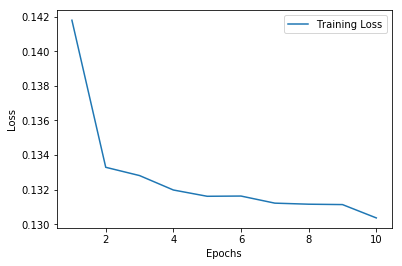

In [205]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

https://www.kaggle.com/akashsri99/deep-learning-iris-dataset-keras

In [206]:
test_y_predictions = model.predict(test_X)

In [207]:
test_y_predictions[:10]

array([[0.94666857, 0.0533314 ],
       [0.9942127 , 0.00578729],
       [0.991156  , 0.00884405],
       [0.9946267 , 0.0053733 ],
       [0.98742074, 0.01257933],
       [0.99585694, 0.00414299],
       [0.99665797, 0.00334207],
       [0.93431586, 0.06568418],
       [0.9275391 , 0.07246088],
       [0.96975994, 0.03024005]], dtype=float32)

In [208]:
test_y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [209]:
y_test_class = np.argmax(test_y,axis=1)
y_pred_class = np.argmax(test_y_predictions,axis=1)

y_pred_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [210]:
y_test_class

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [211]:
y_pred_class.shape

(648,)

In [212]:
assert y_test_class.shape == y_pred_class.shape

In [213]:
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       619
           1       0.00      0.00      0.00        29

   micro avg       0.96      0.96      0.96       648
   macro avg       0.48      0.50      0.49       648
weighted avg       0.91      0.96      0.93       648

[[619   0]
 [ 29   0]]


/Users/wcyn/anaconda3/envs/gnue-irc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
